## More python to cython

In [12]:
# Change path as needed
MAP_PATH = "../tests/pickle_data/GresvanAIE.xz"

In [13]:
# load cell magic things
%load_ext line_profiler
%load_ext Cython

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [14]:
# imports
import matplotlib.pyplot as plt
import numpy as np

from sc2.ids.unit_typeid import UnitTypeId
from sc2.bot_ai import BotAI
from sc2.position import Point2
from sc2.dicts.unit_trained_from import UNIT_TRAINED_FROM
from sc2.data import Race
from sc2.unit import Unit
from sc2.units import Units

from tests.load_bot_from_pickle import get_map_specific_bot

In [15]:
# setup a burnysc2 BOTAI instance we can test with
bot: BotAI = get_map_specific_bot(MAP_PATH)

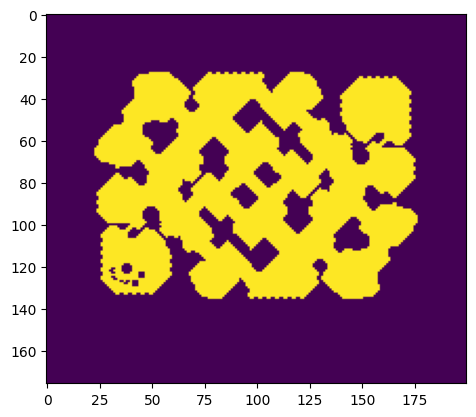

In [16]:
# sanity check that the bot instance is working
plt.imshow(bot.game_info.pathing_grid.data_numpy)

In [17]:
unit = bot.units[0]

## `has_creep()`

Default function checks pixel map, this is slower then checking a numpy array.

In [46]:
%timeit bot.has_creep(unit)

1.1 μs ± 7.88 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [47]:
%timeit bot.has_creep(unit.position)

1.28 μs ± 20.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [48]:
def numpy_has_creep(creep_numpy_grid, position: Point2) -> bool:
    return creep_numpy_grid[position[0], position[1]] == 1

In [49]:
%timeit numpy_has_creep(bot.state.creep.data_numpy, unit.position.rounded)

437 ns ± 5.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


#### Already 2.5 times faster! Try cython

In [50]:
%%cython
from libc.math cimport floor
cimport numpy as cnp
from cython cimport boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
cpdef bint cython_has_creep(
    cnp.ndarray[cnp.npy_bool, ndim=2] creep_numpy_grid,
    (double, double) position,
):
    """Optimized creep checking function with internal rounding"""
    cdef unsigned int x = int(position[0])
    cdef unsigned int y = int(position[1])
    return creep_numpy_grid[x, y] == 1

In [51]:
%timeit cython_has_creep(bot.state.creep.data_numpy, unit.position)

239 ns ± 10.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [52]:
# quick test
creep_copy = bot.state.creep.data_numpy.copy()
creep_copy[5, 10] = 1
cython_has_creep(creep_copy, Point2((5.2, 10.2)))

True

#### Using cython we get ~4.8 times faster over the default burny-sc2 function!

## `in_pathing_grid`

Probably similar to checking `has_creep`

In [ ]:
%timeit bot.in_pathing_grid(unit)

In [18]:
%timeit bot.in_pathing_grid(unit.position)

1.11 μs ± 12 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [19]:
def numpy_in_pathing_grid(pathing_numpy_grid, position: Point2) -> bool:
    return pathing_numpy_grid[position[0], position[1]] == 1

In [23]:
%timeit numpy_in_pathing_grid(bot.game_info.pathing_grid.data_numpy.T, unit.position.rounded)

639 ns ± 40.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [32]:
%%cython
from libc.math cimport floor
cimport numpy as cnp
from cython cimport boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
cpdef bint cython_in_pathing_grid(
    cnp.ndarray[cnp.npy_bool, ndim=2] pathing_numpy_grid,
    (double, double) position,
):
    """Optimized creep checking function with internal rounding"""
    cdef unsigned int x = int(position[0])
    cdef unsigned int y = int(position[1])
    return pathing_numpy_grid[x, y] == 1

In [33]:
%timeit cython_in_pathing_grid(bot.game_info.pathing_grid.data_numpy.T, unit.position)

359 ns ± 2.49 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [9]:
%%cython
from libc.math cimport floor
cimport numpy as cnp
from cython cimport boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
cpdef bint cython_in_pathing_grid_ma(
    cnp.ndarray[cnp.float32_t, ndim=2] pathing_numpy_grid,
    (double, double) position,
):
    """Optimized creep checking function with internal rounding"""
    cdef unsigned int x = int(position[0])
    cdef unsigned int y = int(position[1])
    return pathing_numpy_grid[x, y] == 1

Content of stderr:
/home/tom/.cache/ipython/cython/_cython_magic_734f1db0fb9830cb5c52e3c8067723c3028416a16117b2d2518f3ec3df629856.c: In function ‘__pyx_pw_78_cython_magic_734f1db0fb9830cb5c52e3c8067723c3028416a16117b2d2518f3ec3df629856_1cython_in_pathing_grid_ma’:
/home/tom/.cache/ipython/cython/_cython_magic_734f1db0fb9830cb5c52e3c8067723c3028416a16117b2d2518f3ec3df629856.c:4709:13: warning: ‘result.f1’ may be used uninitialized in this function [-Wmaybe-uninitialized]
 4709 |   __pyx_v_y = ((unsigned int)__pyx_v_position.f1);
      |   ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/home/tom/.cache/ipython/cython/_cython_magic_734f1db0fb9830cb5c52e3c8067723c3028416a16117b2d2518f3ec3df629856.c:9702:37: note: ‘result.f1’ was declared here
 9702 |     __pyx_ctuple_double__and_double result;
      |                                     ^~~~~~
/home/tom/.cache/ipython/cython/_cython_magic_734f1db0fb9830cb5c52e3c8067723c3028416a16117b2d2518f3ec3df629856.c:4701:13: warning: ‘result.f0’ may 

In [10]:
_grid = bot.game_info.pathing_grid.data_numpy.T.astype(np.float32)

In [11]:
%timeit cython_in_pathing_grid(_grid, unit.position)

242 ns ± 6.51 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


#### Using cython we get ~4.4 times faster over the default burny-sc2 function!

In [19]:
%%cython
from libc.math cimport floor
cimport numpy as cnp
from cython cimport boundscheck, wraparound
import numpy as np

@boundscheck(False)
@wraparound(False)
cpdef bint cy_point_below_value(
    cnp.ndarray[cnp.npy_float32, ndim=2] grid,
    (double, double) position,
    double weight_safety_limit = 1.0,
):
    """
    987 ns ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
    Python alternative:
    4.66 µs ± 64.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
    """
    cdef double weight = 0.0
    cdef unsigned int x = int(position[0])
    cdef unsigned int y = int(position[1])
    weight = grid[x, y]
    # np.inf check if drone is pathing near a spore crawler
    return weight == np.inf or weight <= weight_safety_limit

Content of stderr:
/home/tom/.cache/ipython/cython/_cython_magic_748390b7b55db5a55fa43414898e16ec09a4ff34ec0f75a38c2110b0822548ae.c: In function ‘__pyx_pw_78_cython_magic_748390b7b55db5a55fa43414898e16ec09a4ff34ec0f75a38c2110b0822548ae_1cy_point_below_value’:
/home/tom/.cache/ipython/cython/_cython_magic_748390b7b55db5a55fa43414898e16ec09a4ff34ec0f75a38c2110b0822548ae.c:4794:13: warning: ‘result.f1’ may be used uninitialized in this function [-Wmaybe-uninitialized]
 4794 |   __pyx_v_y = ((unsigned int)__pyx_v_position.f1);
      |   ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/home/tom/.cache/ipython/cython/_cython_magic_748390b7b55db5a55fa43414898e16ec09a4ff34ec0f75a38c2110b0822548ae.c:10055:37: note: ‘result.f1’ was declared here
10055 |     __pyx_ctuple_double__and_double result;
      |                                     ^~~~~~
/home/tom/.cache/ipython/cython/_cython_magic_748390b7b55db5a55fa43414898e16ec09a4ff34ec0f75a38c2110b0822548ae.c:4785:13: warning: ‘result.f0’ may be u

In [22]:
grid = bot.game_info.pathing_grid.data_numpy.T.astype(np.float32)

In [24]:
%timeit cy_point_below_value(grid, Point2((5, 10)))


370 ns ± 4.65 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
%timeit cy_point_below_value(grid, Point2((5, 10)))